<a href="https://colab.research.google.com/github/jmoraispk/sionna-rt/blob/main/tutorials/Introduction_MODED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Sionna RT

Ray tracing is a technique to simulate environment-specific and physically accurate channel realizations for a given scene and user position.
Please see the [EM Primer](https://nvlabs.github.io/sionna/rt/em_primer.html) for further details on the theoretical background of ray tracing of wireless channels.

Sionna RT is a open-source hardware-accelerated differentiable ray tracer for radio propagation modeling which is built on top of [Mitsuba 3](https://www.mitsuba-renderer.org/). Mitsuba 3 is a rendering system for forward and inverse light-transport simulation that makes use of the differentiable just-in-time compiler [Dr.Jit](https://drjit.readthedocs.io/en/latest/).

Thanks to Dr.Jit's automatic gradient computation, gradients of functions of channel responses or radio maps with respect to most parameters of the ray tracing process, including material properties, antenna and scattering patterns, orientations, and positions of objects, can be efficiently computed and used in various gradient-based optimization problems.

Sionna RT relies on Mitsuba 3 for the rendering and handling of scenes, e.g., its XML-file format.

Scene files for Mitsuba 3 can be created, edited, and exported with the popular open-source 3D creation suite [Blender](https://www.blender.org/) and the [Mitsuba-Blender add-on](https://github.com/mitsuba-renderer/mitsuba-blender). One can rapdily create scenes from almost any place in the world using [OpenStreetMap](https://www.openstreetmap.org/) and the [Blender-OSM add-on](https://prochitecture.gumroad.com/l/blender-osm). In Sionna, scenes and radio propagation paths can be either rendered through the lens of configurable cameras via ray tracing or displayed with an integrated 3D viewer. For more detail on scene creation and rendering, we refer to [Sionna RT's API documentation](https://nvlabs.github.io/sionna/rt/api/rt.html) and the available [video tutorial](https://youtu.be/7xHLDxUaQ7c).

## Imports

In [ ]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

## Loading and Visualizing Scenes

Sionna RT can either load external scene files (in Mitsuba's XML file format) or it can load one of the [integrated scenes](https://nvlabs.github.io/sionna/rt/api/scene.html#examples).

In this example, we load an example scene containing the area around the Frauenkirche in Munich, Germany.

In [ ]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

To visualize the scene, we can use the `preview` function which opens an interactive preview of the scene.
This only works in Jupyter notebooks.

You can use the following controls:

- Mouse left: Rotate
- Scroll wheel: Zoom
- Mouse right: Move

Please note that only one preview instance per scene can be opened at the same time.
However, multiple scenes can be loaded in parallel.

In [ ]:
if not no_preview:
    scene.preview();

It is often convenient to choose a viewpoint in the 3D preview prior to rendering it as a high-quality image.
The next cell uses the "preview" camera which corresponds to the viewpoint of the current preview image.

In [ ]:
# Only availabe if a preview is open
if not no_preview:
    scene.render(camera="preview", num_samples=512);

One can also render the image to a file as shown below:

In [ ]:
# Only availabe if a preview is open
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650,500]);

Instead of the preview camera, one can also specify dedicated cameras with different positions and `look_at` directions.

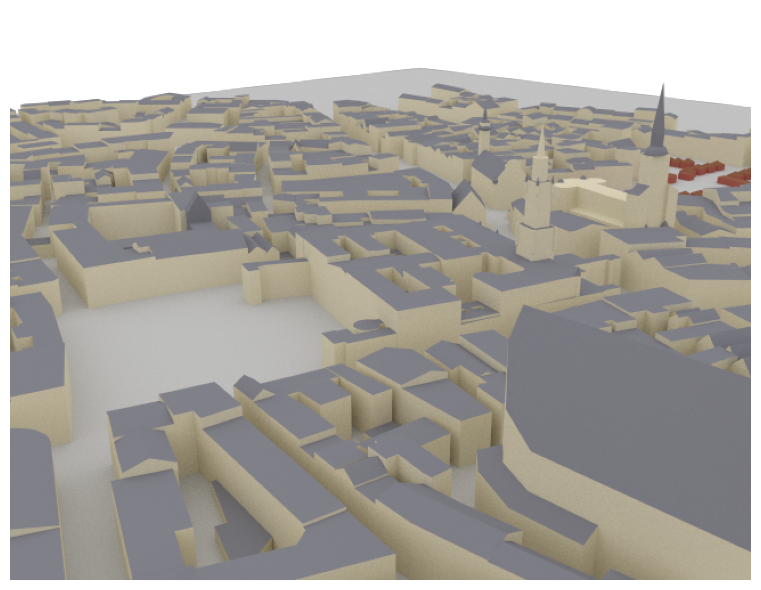

In [ ]:
# Create new camera with different configuration
my_cam = Camera(position=[-250,250,150], look_at=[-15,30,28])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[650, 500], num_samples=512); # Increase num_samples to increase image quality

## Inspecting SceneObjects and Editing of Scenes

A scene consists of multiple [SceneObjects](https://nvlabs.github.io/sionna/rt/api/scene_object.html) which can be accessed in the following way:

In [ ]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=False)
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbcce0>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbd400>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbc9e0>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbdc40>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbdbe0>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbddf0>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbde80>}

In [ ]:
floor = scene.get("floor")

SceneObjects can be transformed by the following properties and methods:
- position
- orientation
- scaling
- look_at

In [ ]:
print("Position (x,y,z) [m]: ", floor.position)
print("Orientation (alpha, beta, gamma) [rad]: ", floor.orientation)
print("Scaling: ", floor.scaling)

Position (x,y,z) [m]:  [[-0.769669, 0.238537, -0.0307941]]
Orientation (alpha, beta, gamma) [rad]:  [[0, 0, 0]]
Scaling:  [1]


More details on these functionalities can be found in the [Tutorial on Loading and Editing of Scenes](https://nvlabs.github.io/sionna/rt/tutorials/Scene-Edit.html).

Every SceneObject has another important property, the `velocity` vector:

In [ ]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


In [ ]:
floor.radio_material

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.123
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

In [ ]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.626
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

In [ ]:
scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 display_radius=2)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

Propagation paths are computed with the help of a [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html).
The next cell shows how such a path solver is instantiated and used.

The parameter `max_depth` determines the maximum number of interactions between a ray and a scene objects.
For example, with a `max_depth` of zero, only LoS paths are considered For a `max_depth` of one, LoS as well as first-order reflections of refractions are considered.  When the argument `synthetic_array` is set to `False`, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array.
Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed.

In [ ]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

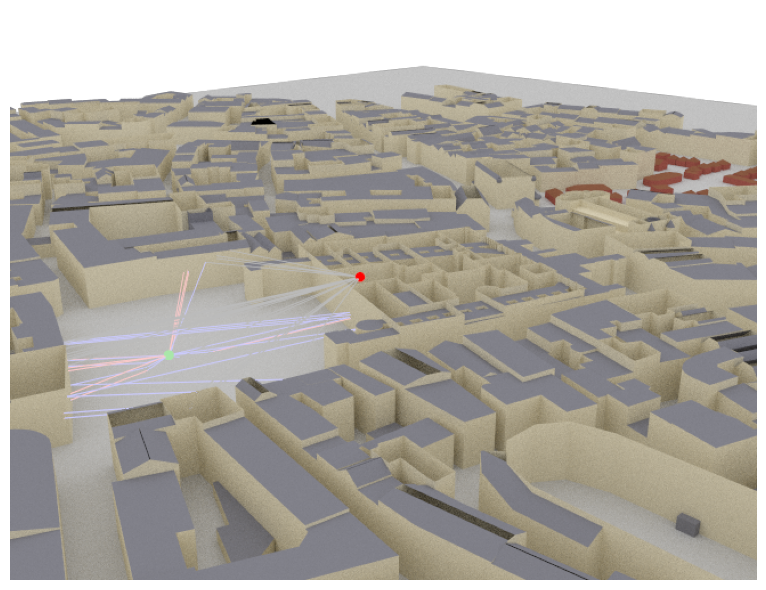

In [ ]:
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

The Paths object contains detailed information about every found path and allows us to generated channel impulse responses and apply Doppler shifts for the simulation of time evolution. For a detailed description, we refer to the developer guide [Understanding the Paths Object](https://nvlabs.github.io/sionna/rt/developer/dev_understanding_paths.html).